In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [39]:
df = pd.read_csv('apple-stock-price-from-19802021/AAPL.csv')

In [40]:
# data inspection
print(df.info())
print(df.head())
print(df.describe())
print("Missing values:", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB
None
         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100178  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094952  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087983  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090160   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092774   73449600
       

In [41]:
# drop duplicate rows
df.drop_duplicates(inplace=True)

In [42]:
# convert date column to datetime format and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [44]:
# feature engineering
def add_features(data):
    # add time-based features
    data['day_of_week'] = data.index.dayofweek
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    data['year'] = data.index.year
    data['week_of_year'] = data.index.isocalendar().week
    data['day_of_year'] = data.index.dayofyear
    
    # add lagged features
    for lag in range(1, 6):
        data[f'lag_{lag}'] = data['Close'].shift(lag)
    
    return data

df = add_features(df).dropna()

<Figure size 1000x600 with 0 Axes>

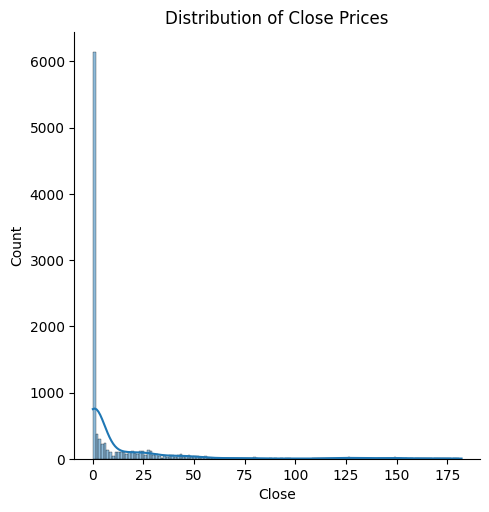

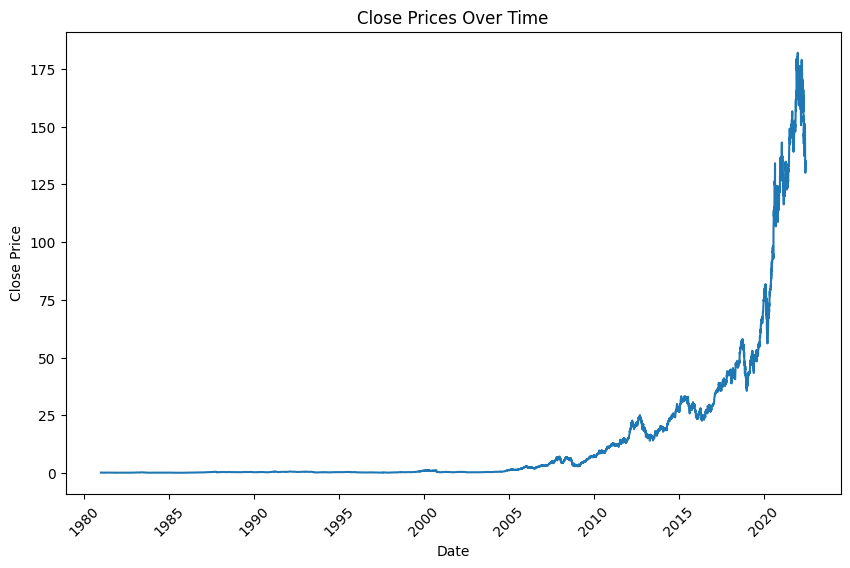

In [45]:
# data visualization
plt.figure(figsize=(10, 6))
sns.displot(data=df, x='Close', kde=True).set(title='Distribution of Close Prices')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='Close').set(title='Close Prices Over Time', xlabel='Date', ylabel='Close Price')
plt.xticks(rotation=45)
plt.show()

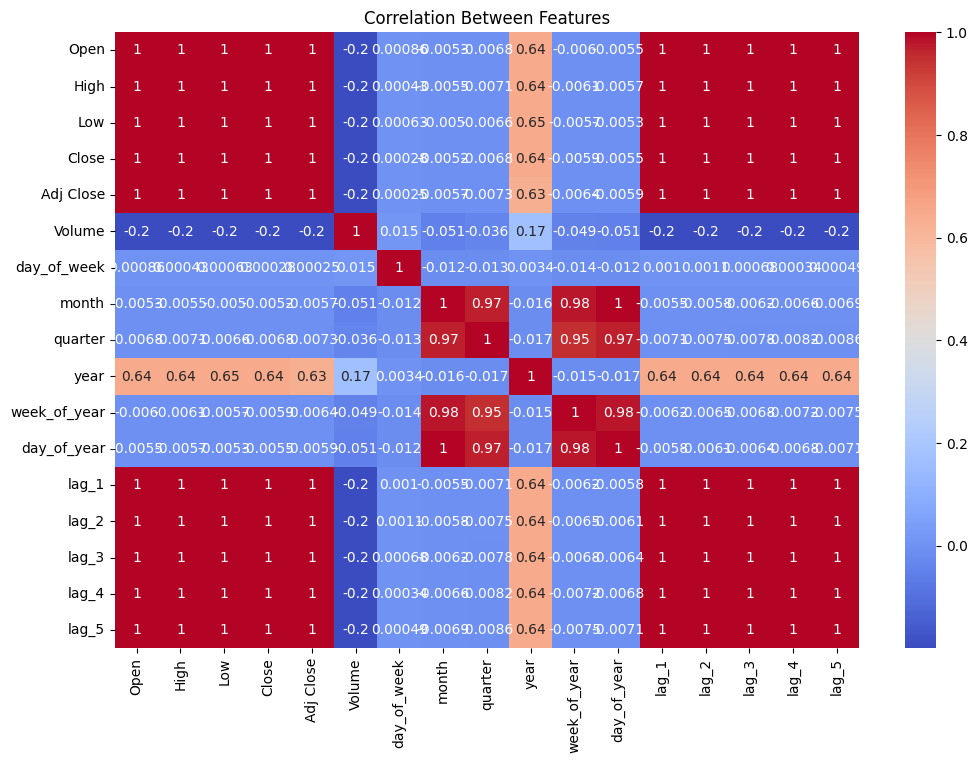

In [46]:
# correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True).set(title='Correlation Between Features')
plt.show()

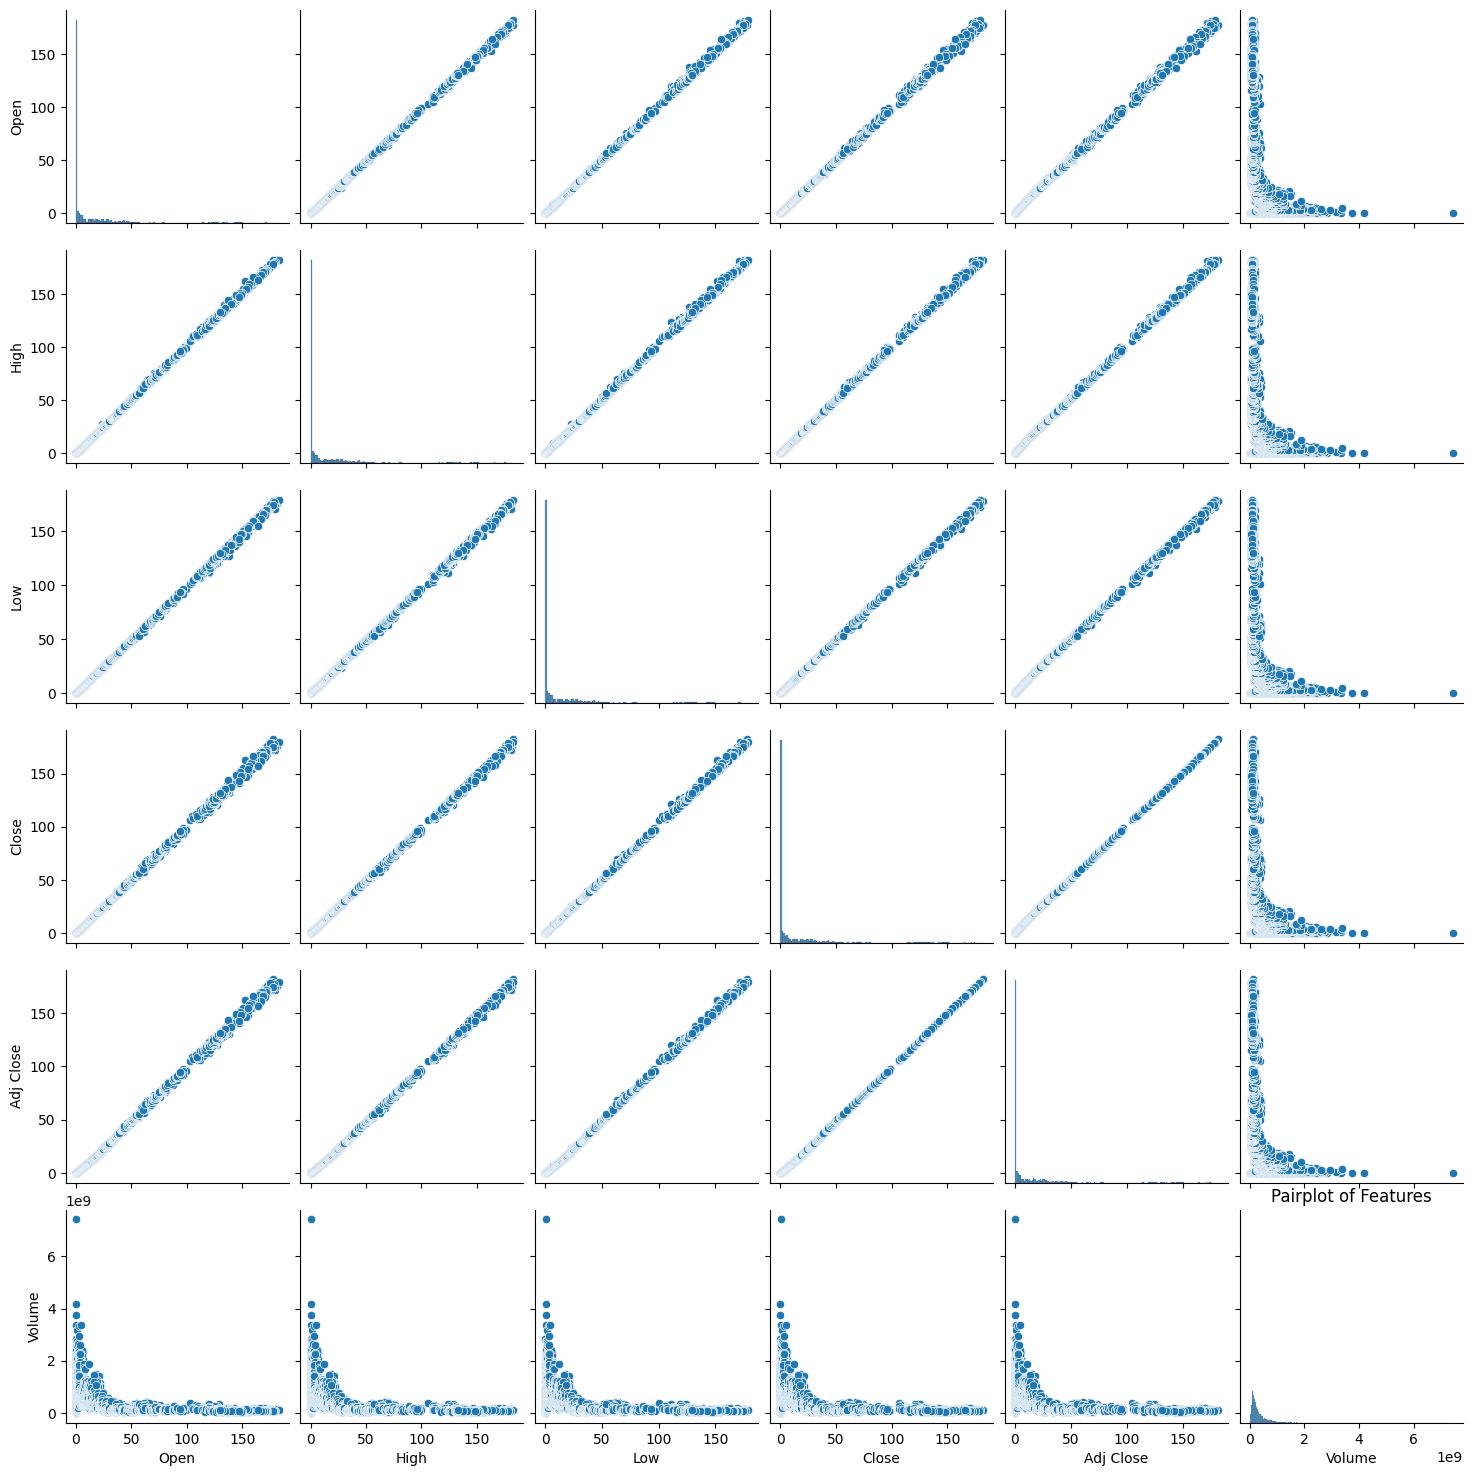

In [47]:
# pairplot of features
sns.pairplot(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])
plt.title('Pairplot of Features')
plt.show()

In [48]:
# split data into training and testing sets
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R² Score': r2_score(y_test, y_pred)
    }

In [50]:
# baseline model
baseline_pred = np.full(y_test.shape, y_train.mean())
baseline_scores = ({
    'MSE': mean_squared_error(y_test, baseline_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, baseline_pred)),
    'MAE': mean_absolute_error(y_test, baseline_pred),
    'R² Score': r2_score(y_test, baseline_pred)
})

In [51]:
# linear regression
lr_model = LinearRegression()
lr_scores = evaluate_model(lr_model, X_train, y_train, X_test, y_test)

In [52]:
# support vector regression
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svr_model = SVR(kernel='linear')
svr_scores = evaluate_model(svr_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [53]:
# random forest regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = evaluate_model(rf_model, X_train, y_train, X_test, y_test)

In [54]:
# LSTM model
# prepare data for LSTM
data = df[['Close']].values
len_train_data = int(len(data) * 0.95)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [55]:
# create training and testing datasets for LSTM
train_data = scaled_data[:len_train_data]
x_train, y_train = [], []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [56]:
# build and train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(x_train, y_train, batch_size=32, epochs=14)

Epoch 1/14


c:\Users\jayum\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 4.4157e-04
Epoch 2/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 9.6532e-05
Epoch 3/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 7.1649e-05
Epoch 4/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 7.4077e-05
Epoch 5/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 5.8007e-05
Epoch 6/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 5.9655e-05
Epoch 7/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 7.2292e-05
Epoch 8/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 5.7812e-05
Epoch 9/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 5.6972e-05
Epoch 10/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 5.4824e-05
Epoch 11/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 5.0599e-05
Epoch 12/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 5.6184e-05
Epoch 13/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 6.0369e-05
Epoch 14/14
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 5.4460e-0

In [57]:
# create testing data for LSTM
test_data = scaled_data[len_train_data - 60:]
x_test = []
y_test = data[len_train_data:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [58]:
# LSTM predictions
predictions = lstm_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [59]:
# evalaute LSTM
lstm_scores = {
    'MSE': mean_squared_error(y_test, predictions),
    'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
    'MAE': mean_absolute_error(y_test, predictions),
    'R² Score': r2_score(y_test, predictions)
}

In [60]:
# summarize results
results = {
    'Model': ['Baseline', 'Linear Regression', 'SVR', 'Random Forest', 'LSTM'],
    'MSE': [baseline_scores['MSE'], lr_scores['MSE'], svr_scores['MSE'], rf_scores['MSE'], lstm_scores['MSE']],
    'RMSE': [baseline_scores['RMSE'], lr_scores['RMSE'], svr_scores['RMSE'], rf_scores['RMSE'], lstm_scores['RMSE']],
    'MAE': [baseline_scores['MAE'], lr_scores['MAE'], svr_scores['MAE'], rf_scores['MAE'], lstm_scores['MAE']],
    'R² Score': [baseline_scores['R² Score'], lr_scores['R² Score'], svr_scores['R² Score'], rf_scores['R² Score'], lstm_scores['R² Score']],
}

evaluation_df = pd.DataFrame(results).set_index('Model')
print(evaluation_df)

                           MSE       RMSE        MAE  R² Score
Model                                                         
Baseline           1061.780791  32.584978  19.730159 -0.000076
Linear Regression     0.064040   0.253061   0.072930  0.999940
SVR                   0.163796   0.404717   0.157211  0.999846
Random Forest         0.131550   0.362698   0.102783  0.999876
LSTM                124.755697  11.169409  10.394666  0.779299


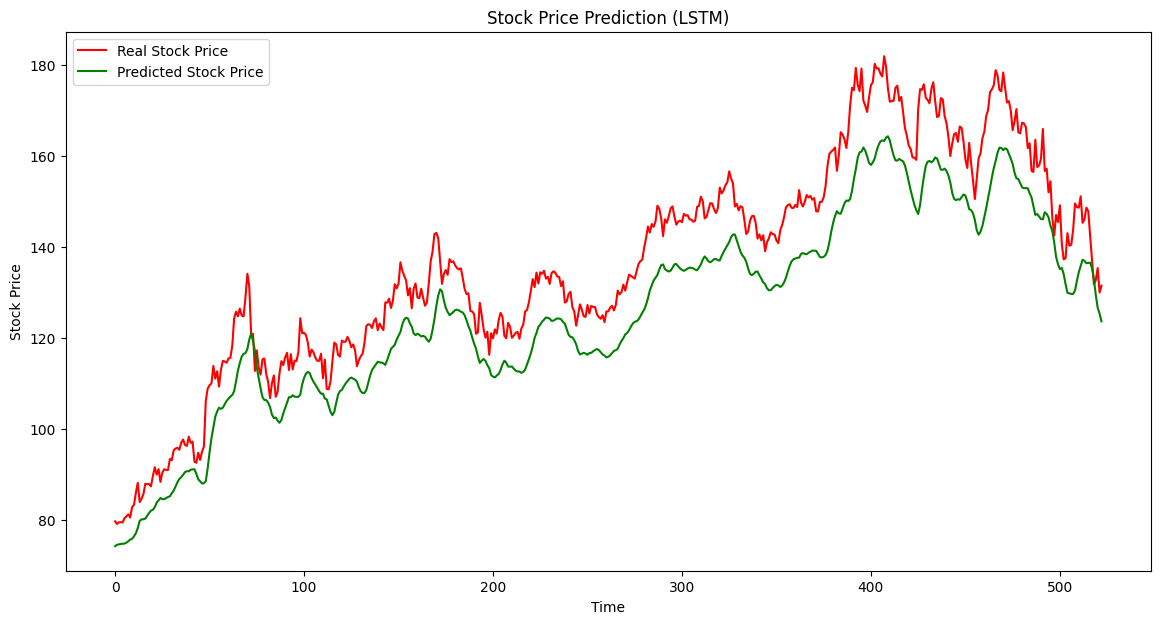

In [61]:
# visualization of predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test, color='red', label='Real Stock Price')
plt.plot(predictions, color='green', label='Predicted Stock Price')
plt.title('Stock Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()